In [36]:
import logging
from tqdm import tqdm
from utils.util import get_Adience_image_paths, get_nearest_number, remove_nones_Adience
from utils.util import resize_square_image, get_meta, read_pickle, write_json
import jsonpickle
import requests
import pickle
import time
import numpy as np
from collections import Counter
import re
import json
from python_on_whales import docker
from pathlib import Path
import pandas as pd
from glob import glob
from PIL import Image
import os

In [57]:
dataset='wiki'
det_score = 0.9
root_dir = Path('./')
data_dir = root_dir.joinpath("data", f"{dataset}_crop")
mat_path = data_dir.joinpath(f"{dataset}.mat")

full_path, dob, gender, photo_taken, face_score, second_face_score, age = get_meta(
    mat_path, dataset)

genders = []
ages = []
img_paths = []
fa_paths = []
sample_num = len(face_score)

metadata = {'total_num_images': len(full_path)}
metadata['removed'] = {}
metadata['removed']['age_not_correct'] = 0
metadata['removed']['gender_not_correct'] = 0
metadata['removed']['image_not_correct'] = 0
metadata['removed']['no_face_detected'] = 0
metadata['removed']['more_than_one_face'] = 0
metadata['removed']['bad_quality'] = 0

for i in tqdm(range(sample_num)):
    if ~(0 <= age[i] <= 100):
        metadata['removed']['age_not_correct']+=1
        continue

    if np.isnan(gender[i]):
        metadata['removed']['gender_not_correct']+=1
        continue

    img_path = str(data_dir / full_path[i][0])
    fa_path = img_path + '.pkl'
    if not os.path.isfile(fa_path):
        metadata['removed']['image_not_correct']+=1
        continue
    
    fa = read_pickle(fa_path)
    
    if len(fa) == 0:
        metadata['removed']['no_face_detected']+=1
        continue

    if len(fa) > 1:
        metadata['removed']['more_than_one_face']+=1
        continue
        
    if fa[0]['det_score'] < det_score:
        metadata['removed']['bad_quality']+=1
        continue

        
    genders.append({0: 'f', 1: 'm'}[int(gender[i])])
    ages.append(int(age[i]))
    img_paths.append(img_path)
    fa_paths.append(fa_path)
    
    
assert len(genders) == len(ages) == len(img_paths) == len(fa_paths)
# outputs = dict(genders=genders, ages=ages, img_paths=img_paths)
# output_path = data_dir.joinpath(f"{dataset}.csv")
# df = pd.DataFrame(data=outputs)


data = []
for gender, age, img_path, fa_path in tqdm(zip(genders, ages, img_paths, fa_paths)):
    fa = read_pickle(fa_path)
    assert len(fa) == 1
    data_sample = {'image_path': img_path,
                  'age': age,
                  'gender': gender,
                  'embedding': fa[0]['normed_embedding']}
    data.append(data_sample)

metadata['genders'] = dict(Counter(genders))
metadata['ages'] = dict(Counter(ages))
write_json(metadata, str(data_dir / "meta-data.json"))
np.save(str(data_dir / "data.npy"), data)
print(metadata)

100%|██████████| 62328/62328 [00:02<00:00, 28140.67it/s]
41472it [00:00, 47770.94it/s]


{'total_num_images': 62328, 'removed': {'age_not_correct': 1781, 'gender_not_correct': 2485, 'image_not_correct': 10909, 'no_face_detected': 3074, 'more_than_one_face': 2179, 'bad_quality': 428}, 'genders': {'m': 31560, 'f': 9912}, 'ages': {28: 1491, 39: 603, 59: 383, 41: 597, 51: 489, 33: 908, 77: 123, 29: 1371, 23: 1657, 25: 1723, 32: 1035, 36: 724, 19: 841, 42: 578, 30: 1275, 27: 1544, 68: 238, 24: 1767, 49: 546, 45: 586, 72: 166, 31: 1150, 52: 453, 47: 549, 56: 395, 55: 441, 57: 402, 53: 438, 54: 417, 46: 533, 67: 264, 78: 119, 48: 525, 43: 591, 62: 334, 61: 335, 37: 670, 26: 1688, 35: 823, 66: 269, 63: 326, 70: 200, 17: 378, 21: 1243, 40: 613, 58: 360, 65: 277, 38: 675, 22: 1590, 50: 471, 20: 1079, 81: 100, 34: 852, 74: 153, 76: 144, 95: 14, 15: 112, 73: 130, 16: 221, 60: 355, 75: 151, 44: 579, 82: 91, 85: 60, 64: 275, 69: 227, 18: 619, 79: 112, 84: 66, 86: 59, 90: 35, 88: 36, 80: 100, 91: 49, 87: 52, 71: 202, 13: 50, 83: 79, 14: 82, 93: 11, 0: 3, 10: 13, 12: 24, 94: 11, 92: 26, 9

In [56]:
len(fa)

1

In [53]:
data_dir / "data.npy"

PosixPath('data/wiki_crop/data.npy')

In [38]:
data_dir / "meta-data.json"

PosixPath('data/wiki_crop/meta-data.json')

In [33]:
len(genders)

41472

In [26]:
fa_path

'data/wiki_crop/80/999980_1954-06-11_2008.jpg.pkl'

In [14]:
outputs.keys()

dict_keys(['genders', 'ages', 'img_paths'])

In [9]:
data_dir

PosixPath('data/wiki_crop')

In [23]:
dataset='wiki'
root_dir = Path('./')
data_dir = root_dir.joinpath("data", f"{dataset}_crop")
mat_path = data_dir.joinpath(f"{dataset}.mat")

full_path, dob, gender, photo_taken, face_score, second_face_score, age = get_meta(
    mat_path, dataset)

print(len(full_path))
genders = []
ages = []
img_paths = []
sample_num = len(face_score)

for i in tqdm(range(sample_num)):
    if ~(0 <= age[i] <= 100):
        continue

    if np.isnan(gender[i]):
        continue

    genders.append({0: 'f', 1: 'm'}[int(gender[i])])
    ages.append(age[i])
    img_paths.append(full_path[i][0])

outputs = dict(genders=genders, ages=ages, img_paths=img_paths)
output_path = data_dir.joinpath(f"{dataset}.csv")
df = pd.DataFrame(data=outputs)

meta_data = {}
for index, row in tqdm(df.iterrows()):
    gender = row.genders
    age = row.ages
    img_path = row.img_paths
    img_path = data_dir / img_path
    fa_path = str(img_path) + '.pkl'
    
    if not os.path.isfile(fa_path):
        continue

    fa = read_pickle(fa_path)
# for fa_path in tqdm(glob(str(data_dir / '*/*.pkl'))):
#     pass


 96%|█████████▌| 59722/62328 [00:00<00:00, 300724.39it/s]

62328


100%|██████████| 62328/62328 [00:00<00:00, 297493.35it/s]
58062it [00:07, 7943.58it/s]


TypeError: object of type 'method' has no len()

In [19]:
img_path

PosixPath('data/wiki_crop/17/10000217_1981-05-05_2009.jpg')

In [15]:
img_path

'80/999980_1954-06-11_2008.jpg'

In [17]:
data_dir / img_path

PosixPath('data/wiki_crop/80/999980_1954-06-11_2008.jpg')

In [17]:
row

genders                                  f
ages                                    54
img_paths    80/999980_1954-06-11_2008.jpg
Name: 58061, dtype: object

In [19]:
row.genders

'f'

In [20]:
row.ages

54

In [21]:
row.img_paths

'80/999980_1954-06-11_2008.jpg'

In [164]:
import pickle

with open('./foo.pkl' ,'rb') as stream:
    foo = pickle.load(stream)

In [167]:
foo.config

OrderedDict([('name', 'MLPAge'),
             ('n_gpu', 0),
             ('arch',
              OrderedDict([('type', 'MLPAge'),
                           ('args',
                            OrderedDict([('num_classes', 2),
                                         ('dropout', 0.5),
                                         ('num_layers', 5)]))])),
             ('data_loader',
              OrderedDict([('type', 'AgeDataLoader'),
                           ('args',
                            OrderedDict([('data_dir', 'data/'),
                                         ('batch_size', 64),
                                         ('shuffle', True),
                                         ('validation_split', 0.1),
                                         ('num_workers', 8),
                                         ('eval_batch_size', 128),
                                         ('dataset', 'Adience'),
                                         ('test_cross_val', 4)]))])),
             (

In [179]:
foo.config['lr_scheduler']['args'].update({'max_lr': foo.config['optimizer']['args']['lr']})

In [180]:
foo.config

OrderedDict([('name', 'MLPAge'),
             ('n_gpu', 0),
             ('arch',
              OrderedDict([('type', 'MLPAge'),
                           ('args',
                            OrderedDict([('num_classes', 2),
                                         ('dropout', 0.5),
                                         ('num_layers', 5)]))])),
             ('data_loader',
              OrderedDict([('type', 'AgeDataLoader'),
                           ('args',
                            OrderedDict([('data_dir', 'data/'),
                                         ('batch_size', 64),
                                         ('shuffle', True),
                                         ('validation_split', 0.1),
                                         ('num_workers', 8),
                                         ('eval_batch_size', 128),
                                         ('dataset', 'Adience'),
                                         ('test_cross_val', 4)]))])),
             (

Namespace(arch={'type': 'MLPAge', 'args': {'num_classes': 2, 'dropout': 0.5, 'num_layers': 5}}, data_loader={'type': 'AgeDataLoader', 'args': {'data_dir': 'data/', 'batch_size': 64, 'shuffle': True, 'validation_split': 0.1, 'num_workers': 8, 'eval_batch_size': 128, 'dataset': 'Adience', 'test_cross_val': 4}}, loss='cse', lr_scheduler={'type': 'OneCycleLR', 'args': {'anneal_strategy': 'linear'}}, metrics=['accuracy'], n_gpu=0, name='MLPAge', optimizer={'type': 'AdamW', 'args': {'lr': 0.001, 'weight_decay': 0.1}}, trainer={'epochs': 50, 'save_dir': 'saved/', 'save_period': 1, 'verbosity': 2, 'monitor': 'min val_loss', 'early_stop': 10, 'tensorboard': True})

./data/imdb_crop/12/nm0615312_rm3630074624_1969-10-11_2005.jpg.RESIZED.jpg
(640, 640)
RGB
True


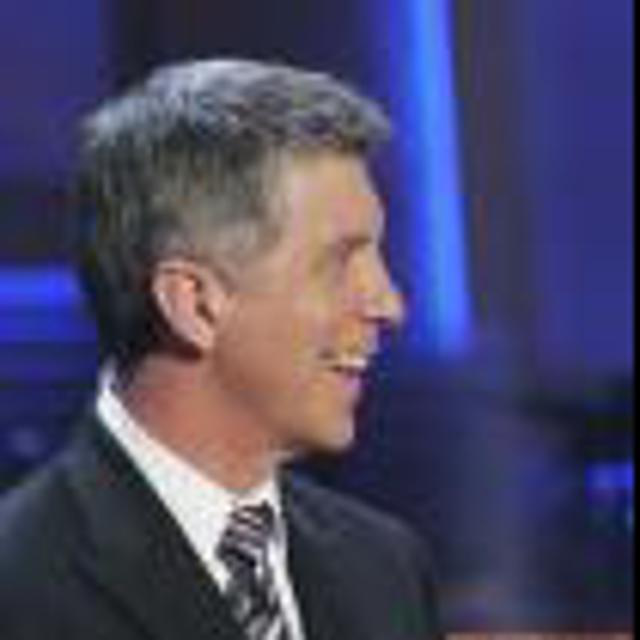

In [146]:
from PIL import Image
import random
from glob import glob

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

image_path = random.choice(glob('./data/*/*/*RESIZED.jpg') + glob('./data/*/*/*/*RESIZED.jpg'))
print(image_path)
foo = Image.open(image_path)
print(foo.size), print(foo.mode), print(foo.mode == 'RGB')
foo

(400, 400)


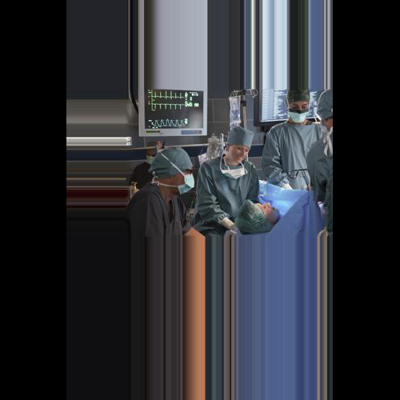

In [3]:
baz = bar.resize((400,400))
print(baz.size)
baz

In [87]:
import torch
torch.cuda.is_available()

True

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import torch

data = np.load('./data/Adience/data-aligned.npy', allow_pickle=True).item()

In [3]:
set([foo['age'] for fold in range(5) for foo in data[fold]]), len(set([foo['age'] for fold in range(5) for foo in data[fold]]))

({1.0, 5.0, 10.0, 17.5, 28.5, 40.5, 50.5, 80.0}, 8)

In [4]:
data[0][0].keys()

dict_keys(['image_path', 'age', 'gender', 'fold', 'embedding'])

In [5]:
data[0][0]['age'], data[0][0]['gender'], data[0][0]['fold']

(28.5, 'f', 0)

In [6]:
torch.cuda.is_available()

True

In [7]:
nn.Linear?

Object `nn.Linear` not found.


In [8]:
len(data[0] + data[1])

7477

In [9]:
data[0][0].keys()

dict_keys(['image_path', 'age', 'gender', 'fold', 'embedding'])

In [10]:
class GenderDataset(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]['embedding']
        y = {'m': 0, 'f': 1}[self.data[idx]['gender']]
        
        return x, y
    
class AgeDataset(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data[idx]['embedding']
        y = {1.0:0, 5.0:1, 10.0:2, 17.5:3, 28.5:4, 40.5:5, 50.5:6, 80.0:7}[self.data[idx]['age']]
        
        return x, y

In [11]:
gd = GenderDataset(data[1]+data[2]+data[3]+ data[4])
gd_test = GenderDataset(data[0])

ad = AgeDataset(data[1]+data[2]+data[3]+ data[4])
ad_test = AgeDataset(data[0])

In [12]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
class MLP(nn.Module):
    '''
      Multilayer Perceptron.
    '''

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4, 2)
        )

    def forward(self, x):
        '''Forward pass'''
        return self.layers(x)


# Set fixed random number seed
torch.manual_seed(42)

# Prepare CIFAR-10 dataset
# dataset = CIFAR10(os.getcwd(), download=True,
#                   transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(gd, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(gd_test, batch_size=32, shuffle=True)

# Initialize the MLP
mlp = MLP()
mlp.to(device)

# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

# Run the training loop
for epoch in range(0, 10):  # 5 epochs at maximum

    # Print epoch
    print(f'Starting epoch {epoch+1}')

    # Set current loss value
    current_loss = 0.0

    # Iterate over the DataLoader for training data
    for i, data in enumerate(trainloader, 0):

        # Get inputs
        inputs, targets = data
#         targets = targets.view(-1, 2)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = mlp(inputs)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 100 == 99:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 100))
            current_loss = 0.0

# Process is complete.
print('Training process has finished.')


Starting epoch 1
Loss after mini-batch   100: 0.693
Loss after mini-batch   200: 0.692
Loss after mini-batch   300: 0.692
Loss after mini-batch   400: 0.691
Starting epoch 2
Loss after mini-batch   100: 0.691
Loss after mini-batch   200: 0.691
Loss after mini-batch   300: 0.690
Loss after mini-batch   400: 0.689
Starting epoch 3
Loss after mini-batch   100: 0.691
Loss after mini-batch   200: 0.690
Loss after mini-batch   300: 0.690
Loss after mini-batch   400: 0.689
Starting epoch 4
Loss after mini-batch   100: 0.690
Loss after mini-batch   200: 0.690
Loss after mini-batch   300: 0.688
Loss after mini-batch   400: 0.689
Starting epoch 5
Loss after mini-batch   100: 0.688
Loss after mini-batch   200: 0.688
Loss after mini-batch   300: 0.686
Loss after mini-batch   400: 0.688
Starting epoch 6
Loss after mini-batch   100: 0.681
Loss after mini-batch   200: 0.677
Loss after mini-batch   300: 0.664
Loss after mini-batch   400: 0.648
Starting epoch 7
Loss after mini-batch   100: 0.639
Loss a

In [13]:
correct = 0
total = 0

mlp.eval()
with torch.no_grad():
    for data in testloader:
        inputs, targets = data
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = mlp(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += targets.size(0)
        
        correct += (predicted == targets).sum().item()
        
correct / total

0.7597977243994943